In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import scipy as sp
import math
import scipy
import copy
import os
import matplotlib.pyplot as plt
from libwallerlab.projects.motiondeblur import blurkernel

# import bluranalysis as analysis

# plt.style.use('deblur')

## Basic DNF / SNR Simulation

In [38]:
# Kernel shape
N = 100

h = np.random.rand(N)
h /= np.mean(h)
h *= 0.5
print(np.mean(h))
H = sp.linalg.circulant(h)
print(H.shape)

# Calculate condition number
_, sigma, _ = np.linalg.svd(H)
kappa = np.max(sigma) / np.min(sigma)
print(kappa)
print(np.linalg.cond(H))

# Invert H^T H 
H_inv = np.linalg.pinv(np.conj(H.T).dot(H))

# Calculate DNF using definition
dnf = np.sqrt(np.trace(H_inv) / H.shape[0])
print(dnf)

# Calculate DNF using FFT
dnf2 = np.sqrt(np.sum(1 / np.abs(np.fft.fft(h)) ** 2) / H.shape[0])
print(dnf2)

# # Check analysis
# dnf3 = analysis.calcDnfFromKernel(h)
# print(dnf3)

0.5000000000000001
(100, 100)
157.23257728339468
157.23257728339462
0.7281565929407047
0.7281565929407804


## Analysing Noise Amplification

In [20]:
from libwallerlab.utilities.simulation import ucb
from libwallerlab.utilities import noise
import llops as yp

# Define size
N = 100
snr = 100
signal_mean = 1000

sigma_1_list = []
sigma_2_list = []
cond_list = []
dnf_list = []
test_list = []

for _ in range(100):
    # Generate object
    x = np.random.rand(N)
    x /= np.mean(x)
    x *= signal_mean

    # Generate noise
    eta = np.random.randn(N) * (signal_mean / snr)

#     print(np.mean(x) / np.std(eta))
#     print(snr)

    # Generate convolution operator
    h = np.random.rand(20)
    h = yp.pad(h, N, center=True)
    H = sp.linalg.circulant(h)

    # Generate measurement
    y = H.dot(x) + eta

    # Invert model
    x_star = np.linalg.pinv(H).dot(y)

    # Calculate RMSE
    rmse = np.sqrt((np.sum(x - x_star) ** 2) / len(x))
    # print(rmse)

    # Calculate dnf
    H_inv = np.linalg.pinv(np.conj(H.T).dot(H))
    dnf = np.sqrt(np.trace(H_inv) / H.shape[0])
    x_fft = np.abs(np.fft.fft(h)) ** 2
    test = np.sum(1 / x_fft) / H.shape[0]
    # print(dnf)

    sigma_1 = np.std(eta)
    sigma_2 = np.std(H_inv.dot(eta))
    
    sigma_1_list.append(sigma_1)
    sigma_2_list.append(sigma_2)
    cond_list.append(np.linalg.cond(H))
    dnf_list.append(dnf)
    test_list.append(test)
    # print(sigma_1 / sigma_2)
    # print(np.sqrt(np.trace(H_inv)))

<IPython.core.display.Javascript object>


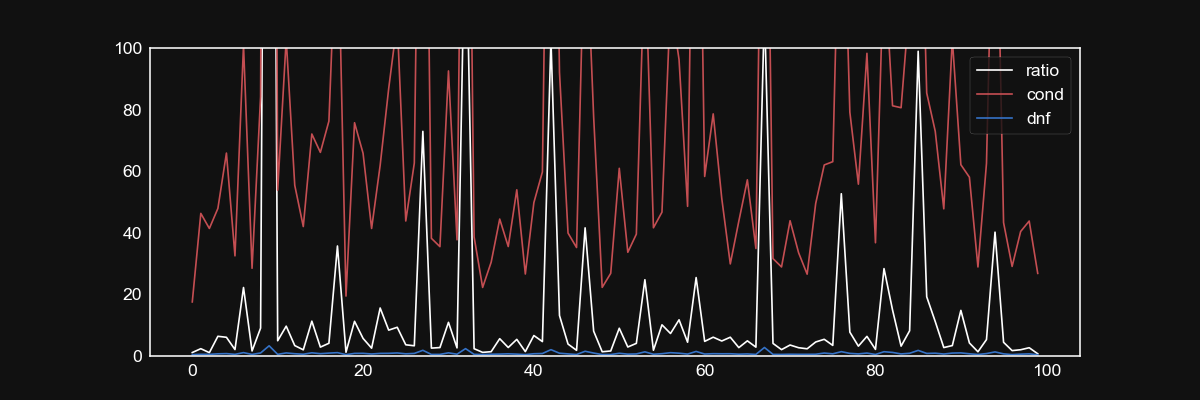

(0, 100)

In [37]:
plt.figure()
# plt.plot(sigma_1_list, label='sigma_1')
# plt.plot(sigma_2_list, label='sigma_2')
# plt.plot(dnf_list, label='dnf')
# plt.plot(test_list, label='test')
plt.plot([s2 / s1 for s1, s2 in zip(sigma_1_list, sigma_2_list)], label='ratio', c='w')
plt.plot([c for c in cond_list], label='cond', c='r')
plt.plot([(d / 2)  for d in dnf_list], label='dnf', c='b')
plt.legend()
plt.ylim((0,100))